In [ ]:
!pip3 install pandas
!pip3 install fpdf
!pip3 install sklearn
!pip3 install nltk

In [4]:
# --------------- Carregamento das bibliotecas e da base de dados  --------------- #

import scipy
from fpdf import FPDF
import numpy as np
import matplotlib
import pandas
import sklearn
import sys
import nltk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
from collections import OrderedDict
from math import pi
from nltk.tokenize import word_tokenize, sent_tokenize
from cogroo_interface import Cogroo, Token
nltk.download('rslp')
# Socket que permitirá a comunicação do Python com a JVM :
    #java -jar cogroo4py.jar

# Load dataset
form = "bancodedados_textos.csv"
parametros = ['Avaliado','Pontualidade', 'Assiduidade', 'Liderança', 'Proatividade', 'Comunicação', 'Organização', 'Trabalho em Equipe', 'Paciência','Empatia', 'start', 'stop', 'continue']
dataset = pandas.read_csv(form, names=parametros)

print("Done!")


[nltk_data] Downloading package rslp to C:\Users\Jessica
[nltk_data]     Feliciano\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
Done!


In [40]:
#gerando pdf do relatório --- ainda não está pronto

#referencia da biblioteca
#https://pyfpdf.readthedocs.io/en/latest/ReferenceManual/index.html
#dimensões da folha A4:  210 mm de largura e 297 mm de altura
#dimensões da folha A5:  210mm de largura e 148mm de altura

title_l = "Feedback 360°"
title_r = "EMPRESA"
#pdf.cell(200, 10, txt="EMPRESA_NAME", align="R", border = 1, fill = True)

class PDF(FPDF):
    #cabeçalho
    def header(self):
        self.set_text_color(17,85,204)
        self.set_font('Helvetica', 'BI', 14)
        self.cell(20, 10, title_l)
        self.image('logo_empresa.png',170, 10,30)
        self.line(10, 23, 200, 23)
        # Line break
        self.ln(20)

    # Page footer
    def footer(self):
        self.image('iotilapia.png', 170, 120,30)

    

pdf = PDF('L', 'mm', 'A5')
pdf.alias_nb_pages()
pdf.add_page()
pdf.set_font('Times', 'B', 30)
pdf.output('Modelo_Relatorio360.pdf', 'F')


''

Avaliado 0 :



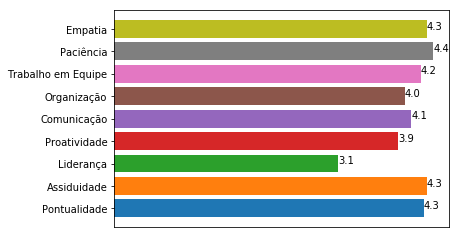

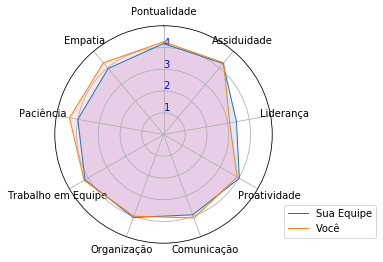

Avaliado 1 :



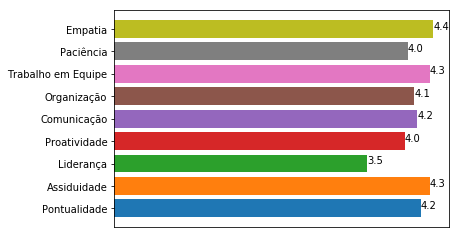

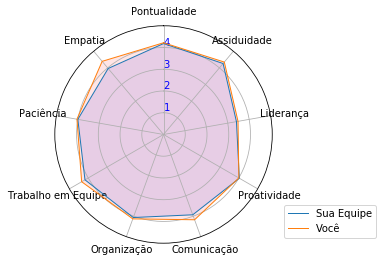

Avaliado 2 :



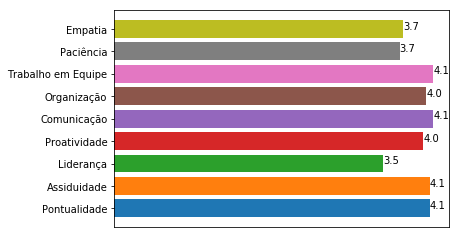

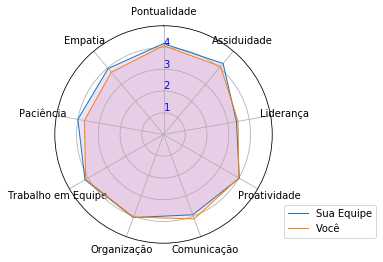

Avaliado 3 :



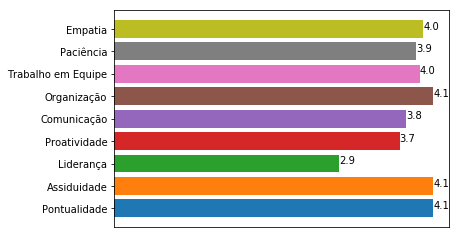

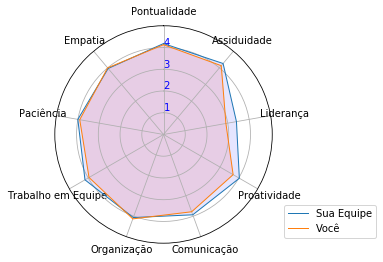

Avaliado 4 :



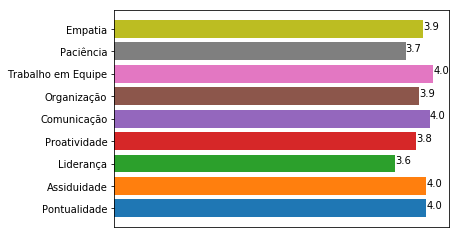

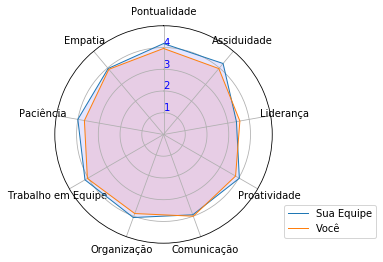

In [2]:
# --------------- Análise Estatística das Competências --------------- #
# Saída:                                                               #
#       1. Tabela com média por avaliado em cada competência           #
#       2. Gráfico barra com média por avaliado em cada competência    #
#       3. Gráfico radar com média da equipe e do avaliado             #
# -------------------------------------------------------------------- #

# Take1 - Informações contidas no relatório
# 1.Resumo dos resultados 

#def draw_radar()
#print(dataset.groupby('Avaliado').mean())

media_avaliados = dataset.groupby('Avaliado').mean()

competencia = []
nota = []


#print(len(dataset.mean()))
len(media_avaliados)

for i in range (5):
    avaliado = media_avaliados.index[i]  #recebe o nome do avaliado
    print("Avaliado",avaliado,":\n")
    j = 0
    competencia.clear()                  #limpa os vetores a cada novo avaliado
    nota.clear()

# Carrega o vetor com as competencias e respectivas médias
    for j in range(9): 
        competencia.insert(j,media_avaliados.columns[j])
        nota.insert(j, media_avaliados.loc[avaliado, competencia[j]])
        plt.text(nota[j],competencia[j],str(round(nota[j],1)))
        plt.barh(competencia[j], nota[j]) 

    
# Gráfico de barras
    plt.gca().axes.get_xaxis().set_visible(False)   #exclui eixo x
    #plt.savefig("barh"+str(avaliado)+".png") #salvando gráfico como imagem
    plt.show()
    
    media = dataset.mean() 
    media_geral = media[1:]
    #print(media_geral.index[i],":\n",media_geral[i])
        
    N = len(media_geral)
    
# Ângulo do radar = 2pi/quantidade de competencias 
    angles = [n / float(N) * 2 * pi for n in range(N)] 
    angles += angles[:1]  #completando o círculo 360.
    
# Initialise the spider plot
    ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet -- indexa cada ângulo à atribuição
    plt.xticks(angles[:-1], media_geral.index)

# Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1,2,3,4],["1", "2", "3", "4"], color="blue")
    plt.ylim(0,5)

# Radar do grupo:
    values=media_geral.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Sua Equipe")
    ax.fill(angles, values, 'b', alpha=0.1)

# Radar individual
    values = nota
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Você")
    ax.fill(angles, values, 'r', alpha=0.1)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.2))
    #plt.savefig("radar"+str(avaliado)+".png")
    plt.show()
    
    #escrevendo as imagens no pdf:
    
  #  pdf.write(10,"Avaliado_"+str(avaliado)+":\n")
   # pdf.image("radar"+str(avaliado)+".png", 30,30)
    #pdf.image("barh"+str(avaliado)+".png",30,140)
    #pdf.output('Avaliado_'+str(avaliado)+'.pdf')



(506, 9) 



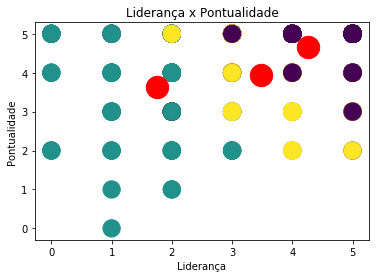

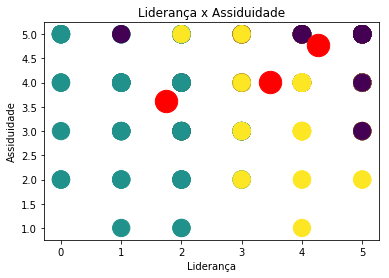

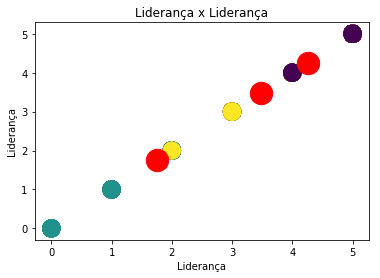

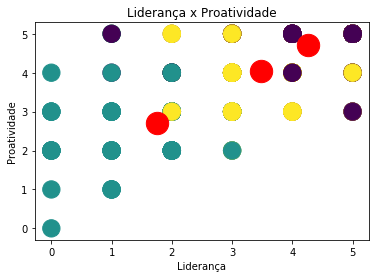

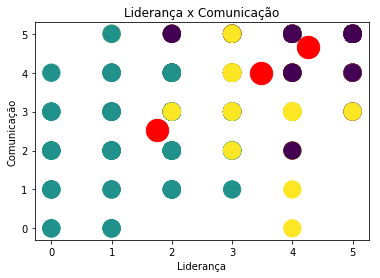

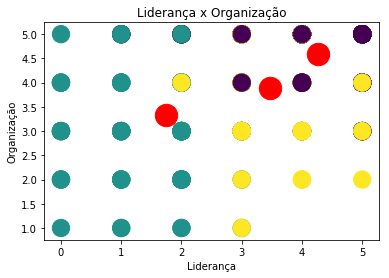

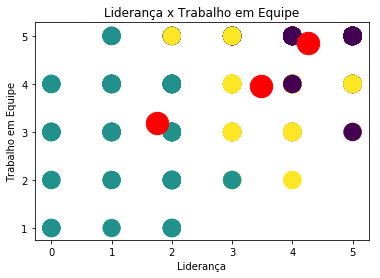

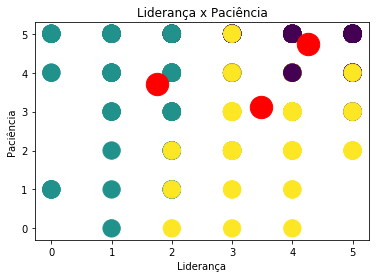

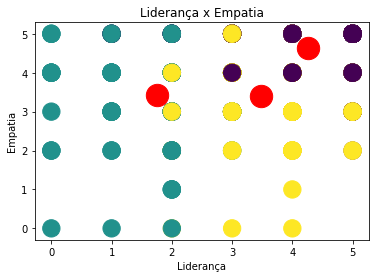

In [3]:
# --------------- Análise Estatística das Competências --------------- #
# Saída:                                                               #
#       5. Clusterização considerando todas as atribuições,            # 
#       com visualização em pares.                                     #
# -------------------------------------------------------------------- #


f1 = dataset["Liderança"].values
f2 = dataset["Trabalho em Equipe"].values
f3 = dataset["Proatividade"].values

#X = np.array(list(zip(f1,f2,f3))) 

# Fazendo clusterização com todos os atributos
X = dataset.loc[:,'Pontualidade':'Empatia'].values
#print(dataset.loc[:,'Pontualidade':'Empatia'].values,"\n")

print(X.shape,"\n")


# Number of clusters
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
#print(centroids,"\n")
#print(centroids,"\n \n",centroids[:,2],"\n \n",centroids[:, 6],"\n")

#print("X[2]:", X[:, 2],"\n f1:", f1)

atrib = 2 #liderança no vetor X

#print("Atributo:\n", dataset.columns[atrib], "\n",X[:,atrib])

for i in range(9): 
    plt.scatter(X[:, atrib], X[:,i], s=300, c = kmeans.labels_)
    plt.scatter(centroids[:, atrib], centroids[:, i], s = 500, c = 'red',label = 'Centroids')
    plt.title(dataset.columns[atrib+1]+' x '+dataset.columns[i+1])
    plt.xlabel(dataset.columns[atrib+1])
    plt.ylabel(dataset.columns[i+1])
    #plt.legend()   #ajeitar a posiçao da legenda
    plt.show()

Pontualidade          4.181818
Assiduidade           4.260870
Liderança             3.405138
Proatividade          4.025692
Comunicação           3.930830
Organização           4.065217
Trabalho em Equipe    4.171937
Paciência             4.001976
Empatia               3.962451
dtype: float64


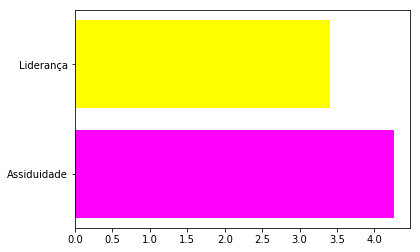

In [4]:
# --------------- Análise Estatística das Competências --------------- #
# Saída:                                                               #
#       6. Gráfico com o pior e o melhor atributo da equipe            #
# -------------------------------------------------------------------- #

atributos = dataset.mean()[1:]
print(atributos)
#colors = plt.cm.BuPu(np.linspace(0, 0.5, 3))

plt.barh(atributos.idxmax(), atributos.max(), color = "magenta")
plt.barh(atributos.idxmin(), atributos.min(), color = "yellow")
plt.show()


In [14]:
#Análise de textos usando NLTK - links úteis:
#https://medium.com/@viniljf/utilizando-processamento-de-linguagem-natural-para-criar-um-sumariza%C3%A7%C3%A3o-autom%C3%A1tica-de-textos-775cb428c84e
#https://textminingonline.com/dive-into-nltk-part-i-getting-started-with-nltk
#http://blog.chapagain.com.np/natural-language-processing-nlp-basic-introduction-to-nltk-python/

#import nltk

#Fazer o download de todas as bibliotecas usando "nltk.download()"
#Para bibliotecas específicas:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('words')
#nltk.download('rslp')

In [6]:
# --------------------- Análise dos Comentários ---------------------- #
# Saída:                                                               #
#       9. Organizando os comentários                                  #
#          9.1. Respostas "nulas" (ruído branco) do texto excluídas    #
#          9.2. Agrupar comentários em um texto                        #
#               9.2.1.  Por start, stop, continue                      #
#               9.2.2.  Por avaliado e start, stop, continue           #
# -------------------------------------------------------------------- #

#ssc_avaliado = dataset.loc[:,['Avaliado','start', 'stop', 'continue']]
#print(ssc_avaliado)

start = dataset.loc[:,['Avaliado', 'start']]
stop = dataset.loc[:,['Avaliado', 'stop']]
cont = dataset.loc[:,['Avaliado', 'continue']]

ruido_branco = ['não sei', 'nao sei', 'nada', 'não tenho opinião','complaints', 'não tenho uma opinião', "°"]

#print(start.values[0,1])

for i in range(stop.shape[0]):
    if len(start.values[i,1]) <= 3 or any(substring in start.values[i,1].lower() for substring in ruido_branco) == True:
        start.at[i, 'start'] = ""
    if len(str(stop.values[i,1])) <= 3 or any(substring in str(stop.values[i,1]).lower() for substring in ruido_branco) == True:
        stop.at[i, 'stop'] = ""
    if len(str(cont.values[i,1])) <= 3 or any(substring in str(cont.values[i,1]).lower() for substring in ruido_branco) == True:
        cont.at[i, 'continue'] = ""

#print(start,'\n') #imprime no formato de tabela o avaliado e a mensagem

# Listas de textos auxiliares:
# Guarda tudo que foi dito em start, stop, continue separadamente. 
# Se colocar o índice, pega um dos vetores = um dos avaliados
text_start = []
text_stop = []
text_cont = []        

# Lista de textos com os comentários para cada avaliado:
for i in range(len(media_avaliados)):
    text_start.insert(i," ".join(start[start['Avaliado'] == i]['start']))
    text_stop.insert(i," ".join(stop[stop['Avaliado'] == i]['stop']))
    text_cont.insert(i," ".join(cont[cont['Avaliado'] == i]['continue']))    

#print(text_start) #o texto todo junto do start, stop, continue. 

# Converter lista em string para poder usar a propriedade lower
string_start = ' '.join(text_start)
string_stop = ' '.join(text_stop)
string_cont = ' '.join(text_cont)


#print(string_start.lower())
print(text_start[2])
#tokens_start = nltk.word_tokenize(string_start)

#print(tokens_start)
#print("Respostas para o avaliado 0:\nStart:",text_start[i],"\n\nStop:", text_stop[0],"\n\nContinue:",text_cont[0])



Se organizar no seu tempo. Começar a trabalhar um pouco seus aspectos de liderança (mesmo ele tendo esses aspectos acho que ele pode melhorar um pouco mais)  Concentrar-se mais Falar mais, mais expressivo Ser mais empático  Começar a expor e aparecer mais para a equipe pois seu trabalho não é notado Aparecer durante o expediente  Acho que alguma vezes Renata fica um pouco impaciente diante de algumas situações, acho que ela poderia melhorar isso   Ser menos tímido Ser mais rígido em algumas situação  Escutar as outras pessoas quando for criticado Interagir melhor com a equipe, aprender a ouvir críticas   Ser mais paciente Agilidade 


In [5]:
# --------------------- Análise dos Comentários ---------------------- #
# Sem saída.                                                           #
#                         Funções importantes.                         #
# -------------------------------------------------------------------- #

# Inicializando machine learning para textos

#biblioteca NLTK(Natural Language Toolkit)
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Coletando uma frase do banco de dados
setence = dataset["start"][15]

# Função tokenize --> separa as palavras de uma frase/texto
tokens = nltk.word_tokenize(setence)

# Função inversa: agrupa as palavras novamente no texto/frase:
text = nltk.Text(tokens)

# Função sent_tokenize --> separa as sentenças de um /texto
sentencas = sent_tokenize(setence)

# Função Concordance --> retorna a palavra buscada com o contexto em torno dela
concordance = text.concordance('palavra_chave')

# Função "similar" --> retorna palavras semelhantes à buscada
similar = text.similar('opinião') #não funciona mto bem...
print (similar)

# Função pos_tag --> classifica as palavras em grupos
tagged = nltk.pos_tag(tokens)

#palavras = word_tokenize(texto.lower())

print(setence,"\n")
print("#de repetições da palavra 'mais':",setence.count('mais'),"\n")
print(text, "tamanho:", len(text),"\n")
print(tokens,"tamanho:", len(tokens),"\nSem repetições:", set(tokens),"tamanho:", len(set(tokens)),"\n")
print(tagged)

No matches
No matches
None
Se mostrar mais presente nas discussões do grupo e opinar mais sobre como o trabalho deve ser feito. 

#de repetições da palavra 'mais': 2 

<Text: Se mostrar mais presente nas discussões do grupo...> tamanho: 19 

['Se', 'mostrar', 'mais', 'presente', 'nas', 'discussões', 'do', 'grupo', 'e', 'opinar', 'mais', 'sobre', 'como', 'o', 'trabalho', 'deve', 'ser', 'feito', '.'] tamanho: 19 
Sem repetições: {'como', 'Se', 'do', 'e', 'grupo', 'discussões', 'sobre', 'nas', 'trabalho', 'deve', 'feito', 'mostrar', 'opinar', 'ser', 'mais', '.', 'o', 'presente'} tamanho: 18 

[('Se', 'NNP'), ('mostrar', 'NN'), ('mais', 'NN'), ('presente', 'NN'), ('nas', 'NNS'), ('discussões', 'VBP'), ('do', 'VBP'), ('grupo', 'VB'), ('e', 'VB'), ('opinar', 'JJ'), ('mais', 'NN'), ('sobre', 'NN'), ('como', 'NN'), ('o', 'JJ'), ('trabalho', 'NN'), ('deve', 'VBP'), ('ser', 'NN'), ('feito', 'NN'), ('.', '.')]


In [17]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from collections import defaultdict
from string import punctuation


# ------- coletar as palavras que não dão para extrair muito sentido + retira pontuações
stop_words = set(stopwords.words('portuguese') + list(punctuation))
word_tokens = word_tokenize(string_start.lower())
filtered_words = [word for word in word_tokens if word not in stop_words]
#fitered_text = " ".join(filtered_words)
#cogroo.lemmatize(filtered_words)

frequencia = FreqDist(filtered_words)
palavras_importantes = defaultdict(int)

#criando um dicionário com as palavras mais importantes do texto
for i in enumerate(word_tokens):
    for word in word_tokens:
        if word in frequencia:
            palavras_importantes[i] += frequencia[word]

print(palavras_importantes)


defaultdict(<class 'int'>, {(0, 'gabriel'): 13120, (1, 'é'): 13120, (2, 'uma'): 13120, (3, 'pessoa'): 13120, (4, 'que'): 13120, (5, 'se'): 13120, (6, 'mostra'): 13120, (7, 'disponível'): 13120, (8, 'a'): 13120, (9, 'fazer'): 13120, (10, 'o'): 13120, (11, 'que'): 13120, (12, 'o'): 13120, (13, 'orientarem'): 13120, (14, '.'): 13120, (15, 'durante'): 13120, (16, 'os'): 13120, (17, 'desafios'): 13120, (18, 'não'): 13120, (19, 'se'): 13120, (20, 'mostrou'): 13120, (21, 'uma'): 13120, (22, 'pessoa'): 13120, (23, 'de'): 13120, (24, 'iniciativa'): 13120, (25, '.'): 13120, (26, 'ele'): 13120, (27, 'precisa'): 13120, (28, 'trabalhar'): 13120, (29, 'isso'): 13120, (30, '.'): 13120, (31, 'ele'): 13120, (32, 'deve'): 13120, (33, 'se'): 13120, (34, 'mostrar'): 13120, (35, 'mais'): 13120, (36, ','): 13120, (37, 'expor'): 13120, (38, 'quais'): 13120, (39, 'são'): 13120, (40, 'suas'): 13120, (41, 'qualidades'): 13120, (42, '.'): 13120, (43, 'delegar'): 13120, (44, 'mais'): 13120, (45, 'funções'): 13120

In [8]:
#Utilzação do Cogroo para classificação gramatical:
#tutorial: #instalar java, instalar py4j, baixar dois arquivos no link 
#https://github.com/gpassero/cogroo4py/blob/master/README.md

cogroo = Cogroo.Instance()
def _pos_tags(self):
        pos = {}
        pos.update({"n": "substantivo"})
        pos.update({"prop": "nome próprio"})
        pos.update({"art": "artigo"})
        pos.update({"pron": "pronome"})
        pos.update({"pron-pers": "pronome pessoal"})
        pos.update({"pron-det": "pronome determinativo"})
        pos.update({"pron-indp": "substantivo/pron-indp"})
        pos.update({"adj": "adjetivo"})
        pos.update({"n-adj": "substantivo/adjetivo"})
        pos.update({"v": "verbo"})
        pos.update({"v-fin": "verbo finitivo"})
        pos.update({"v-inf": "verbo infinitivo"})
        pos.update({"v-pcp": "verbo particípio"})
        pos.update({"v-ger": "verbo gerúndio"})
        pos.update({"num": "numeral"})
        pos.update({"prp": "preposição"})
        pos.update({"adj": "adjetivo"})
        pos.update({"conj": "conjunção"})
        pos.update({"conj-s": "conjunção subordinativa"})
        pos.update({"conj-c": "conjunção coordenativa"})
        pos.update({"intj": "interjeição"})
        pos.update({"adv": "advérbio"})
        pos.update({" ' ": "outro"})
        return pos
	
	# pos: "part of speech"
pos = cogroo.pos_tags

print(pos['n'])

substantivo


In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from collections import defaultdict
from string import punctuation

# ------- coletar as palavras que não dão para extrair muito sentido + retira pontuações
stop_words = set(stopwords.words('portuguese') + list(punctuation))
word_tokens = word_tokenize(string_start.lower()) 
filtered_words = [word for word in word_tokens if word not in stop_words]

#print(word_tokens,"\n", filtered_words)

filtered_text = " ".join(filtered_words)

#-------- realizando a classificação gramatical
cogroo = Cogroo.Instance()
filtered_lemas = cogroo.lemmatize(filtered_text)

#print(word_tokens,"\n", filtered_words, "\n", filtered_lemas,"\n")
doc = cogroo.analyze(filtered_lemas)

#doc.sentences[0].tokens
#sentence = doc.sentences
tokens = [(token.lemma, token.pos) for sentence in doc.sentences for token in sentence.tokens]

#print(tokens)

#retirando as pontuações da lista de classificação gramatical
words = [w for w in tokens if w[1] not in list(punctuation)]

#retirando as pontuações da lista de palavras
words_2 = [w for w in words if w[0] not in list(punctuation)]


#Criando um dicionário com as palavras e suas classificações
words = dict(words_2)

#criando uma matriz de todas as classes gramaticais, onde cada linha agrupa todas as palavras de uma classe gramatical
d = defaultdict(list)
for k, v in words_2:
    a = pos[str(v)]
    d[a].append(k)

#verificando a frequencia dos adjetivos, substantivos e verbos:
freq_adj = FreqDist(d['adjetivo'])
freq_sub = FreqDist(d['substantivo'])
freq_verb = FreqDist(d['verbo infinitivo'])

#print(frequencia)
print("Adjetivos mais comuns:\n",freq_adj.most_common(50), "\nSubstantivos mais comuns:\n",freq_sub.most_common(50),"\nVerbos Mais Comuns:\n",freq_verb.most_common(50))


Adjetivos mais comuns:
 [('melhor', 37), ('comunicativo', 12), ('presente', 7), ('maior', 6), ('empático', 5), ('tímido', 4), ('novo', 4), ('proativo', 4), ('pontual', 4), ('claro', 3), ('geral', 3), ('próximo', 3), ('necessário', 3), ('boa', 3), ('principal', 3), ('expressivo', 2), ('paciente', 2), ('diferente', 2), ('específico', 2), ('criativo', 2), ('seguro', 2), ('negativo', 2), ('importante', 2), ('emocional', 2), ('ativo', 2), ('possivel', 2), ('livre', 2), ('prático', 2), ('gabriel', 1), ('disponível', 1), ('brando', 1), ('renata', 1), ('rígido', 1), ('sério', 1), ('português', 1), ('amigável', 1), ('flexível', 1), ('frio', 1), ('direto', 1), ('´r', 1), ('regional', 1), ('lol', 1), ('nao', 1), ('atento', 1), ('responsavel', 1), ('assertivo', 1), ('horário', 1), ('local', 1), ('diverso', 1), ('primeira', 1)] 
Substantivos mais comuns:
 [('atividade', 24), ('equipe', 23), ('comunicação', 16), ('pessoa', 14), ('ideia', 12), ('opinião', 11), ('liderança', 11), ('tempo', 10), ('trab

In [11]:
#--------- Tratamento dos textos usando nltk e CoGroo -------#
#Algoritmo para retornar as 5 principais coisas que os membros/empresa devem começar (start), parar (stop) e continuar(continue) a fazer:
#1 buscar as 5 raízes de maior frequencia no texto (usar: stemmer = nltk.stem.RSLPStemmer())
#2 Verificar se alguma dessas 5 é advérbio e adjetivo simultaneamente - se for, exclui e escolhe a próxima raíz de maior frequencia, de modo que sejam sempre 5 raízes
#3 Transformar essas 5 raízes em substantivos
#retorná-las

#OBS: Não funciona corretamente
#-------------------------------------------------------------#
stemmer = nltk.stem.RSLPStemmer()
from nltk.stem import WordNetLemmatizer as lemma

#função que retorna as palavras mais comuns de uma determinada classificação gramatical

def find_root(grammar_c, roots):
    aux = []
    for i in range(len(roots)):
        next((aux.append(w) for j, w in enumerate(grammar_c) if roots[i] in w), None)
    return aux

#listas de verbos, adjetivos, substantivos -- a lista já está ordenada com base na frequencia das palavras:
adjts = list(OrderedDict(FreqDist(d['adjetivo'])).keys()) 
subs = list(OrderedDict(FreqDist(d['substantivo'])).keys()) 
verbs = list(OrderedDict(FreqDist(d['verbo infinitivo'])).keys()) 

#raízes das palavras do texto
roots = [stemmer.stem(str(word)) for word in filtered_words]
#frequencia das raízes
freq_roots = FreqDist(roots)
#5 raízes de palavras mais comuns
common_roots = dict(freq_roots.most_common(5))

#o loop abaixo retira algumas raízes que são ruídos brancos ou que possuem mais de uma classe gramatical simultanea
i = 1
for w in list(common_roots.keys()):
    if w in d['adjetivo'] and d['advérbio'] or w in ['ser', 'melhorar','ter', 'estar']:
        del common_roots[w]
        x = list(freq_roots.most_common(5+i))
        common_roots.update({str(x[5+(i-1)][0]):x[5+(i-1)][1]})
        i+=1

#lista com as 5 raízes mais comuns após o tratamento de ruído branco (deve ser melhorado!)
common_roots = list(common_roots.keys())

#começamos buscando substantivos nas 5 raízes mais frequentes
common_words = find_root(subs,common_roots)


if common_words != None:
    print("Características que a equipe pode melhorar:\n")
    print(common_words)
    
    if len(common_words)<5: 
        #em seguida busca os adjetivos das 5 raízes mais frequentes
        common_words = find_root(adjts,common_roots)
        print("Adjetivos:\n")   
        print(common_words)
        if len(common_words)<5: 
        #por último, busca os verbos das 5 raízes mais frequentes
            common_words = find_root(verbs,common_roots)
            print("Verbos:\n")   
            print(common_words)

Características que a equipe pode melhorar:

['comunicação', 'trabalho', 'equipe', 'iniciativa', 'falha']


In [12]:
#retornando os adjetivos mais frequentes para cada pessoa:

for i in range (len(text_start)):
    j = 0
    word_tokens = word_tokenize(text_start[i].lower())
    filtered_words = [word for word in word_tokens if word not in stop_words]
    filtered_text = " ".join(filtered_words)
    filtered_lemas = cogroo.lemmatize(filtered_text)
    doc = cogroo.analyze(filtered_lemas)
    tokens = [(token.lemma, token.pos) for sentence in doc.sentences for token in sentence.tokens]
    words = [w for w in tokens if w[1] not in list(punctuation)]
    words_2 = [w for w in words if w[0] not in list(punctuation)]
    
    for j in range(len(words_2)):
        if j>0:
            if words_2[j-1][0] == "menos" or words_2[j-1][0] == "mais" and words_2[j][1] == 'adj':
                print("Avaliado:",i,"\nFrase:\nSer ",words_2[j-1][0], words_2[j][0],"\n")


Avaliado: 2 
Frase:
Ser  menos tímido 

Avaliado: 4 
Frase:
Ser  menos chefe 

Avaliado: 6 
Frase:
Ser  menos tímido 

Avaliado: 11 
Frase:
Ser  menos chato 

Avaliado: 12 
Frase:
Ser  menos tímido 

Avaliado: 12 
Frase:
Ser  menos sobre 

Avaliado: 17 
Frase:
Ser  menos durante 

Avaliado: 20 
Frase:
Ser  menos buscar 

Avaliado: 21 
Frase:
Ser  menos ser 

Avaliado: 21 
Frase:
Ser  menos tímido 



[nltk_data] Downloading package maxent_ne_chunker to C:\Users\Jessica
[nltk_data]     Feliciano\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
<FreqDist with 557 samples and 1378 outcomes>


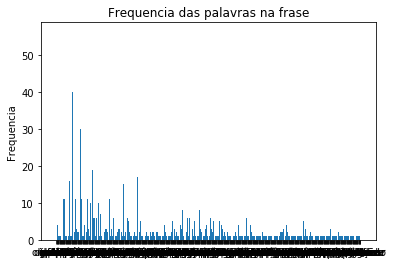

In [18]:

nltk.download('maxent_ne_chunker')
# ------- coletar as palavras que não dão para extrair muito sentido + retira pontuações
stop_words = set(stopwords.words('portuguese') + list(punctuation))
word_tokens = word_tokenize(string_start.lower())

# ------- tirar dos tokens as stopwords
filtered_sentence = [word for word in word_tokens if word not in stop_words]

#print(filtered_sentence)
frequencia = FreqDist(filtered_sentence)
print(frequencia)

# ------- pegar só o radical das palavras
def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras=[]
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

text_radical = Stemming(text_start[0]) 
#Stemming(text_start[0]) 

# ------- frequência das palavras mais ditas, sem dizer qual a palavra -.-
#frequencia = FreqDist(['liderança','paciente','liderança'])
frequencia = FreqDist(filtered_sentence)
#frequencia = FreqDist(text_radical) #não deu certo plotar assim, o gráfico ficou com a freq das letras.
frequencia.max()
# Seria interessante a gente fazer uma manipulaçãozinha na base de dados para aparecer 
# palavras importantes repetidas

#Gráfico da frequencia de palavras -- também não possui boa representação

palavras = frequencia.keys()
y_pos = np.arange(len(palavras))
contagem = frequencia.values()
plt.bar(y_pos, contagem, align='center', alpha=1)
plt.xticks(y_pos, palavras)
plt.ylabel('Frequencia')
plt.title('Frequencia das palavras na frase')
plt.show() # Melhor opção: coletar de alguma forma somente as palavras que a gente quer ver as repetições
# ou seja, fazer mais uma limpeza das palavras.

#print(word_tokens,'\n')

#print(filtered_sentence,'\n')

#print(classes,'\n')

#print(entidades,'\n')

#print(frequencia) # teria que selecionar as palavras chaves antes de ver a frequência delas. 
#print(contagem) #mostra a quantidade de cada palavra na ordem, mas a gente não tem acesso fazendo contagem[4]
#print(palavras) 


In [ ]:
#--- Links para a criação de pdf's

#https://pyfpdf.readthedocs.io/en/latest/Python3/index.html
    
#https://www.blog.pythonlibrary.org/2012/07/10/an-intro-to-pyfpdf-a-simple-python-pdf-generation-library/
#https://pyfpdf.readthedocs.io/en/latest/Python3/index.html

#http://www.fpdf.org/en/doc/index.php
    